<a href="https://colab.research.google.com/github/CPMOliveira/GoogleColab/blob/main/An%C3%A1lise%20de%20Queimadas%20no%20Brasil%20(2020).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Queimadas no Brasil (2020)

## Resumo

Neste notebook, iremos explorar dados territoriais e de queimadas no Brasil utilizando a linguagem Python e as bibliotecas Shapely e GeoPandas.

## 0) Inicialização

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# Others
!pip install bs4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-ameh_wv1
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-ameh_wv1
  Created wheel for geopandas: filename=geopandas-0.9.0+7.gf5c54ed-py2.py3-none-any.whl size=995043 sha256=30757844205ed00a1306c62d38d5e88d273df772e0d5251e83ff42664ef95e40
  Stored in directory: /tmp/pip-ephem-wheel-cache-3w0diyoh/wheels/91/24/71/376c9c67192694168352a

In [ ]:
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt
import seaborn as sns

import os
from urllib.request import urlretrieve
import requests
import zipfile
from bs4 import BeautifulSoup

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

## 1) Fontes de dados

### 1.1) Queimadas no Brasil em 2020

* Fonte: [Instituto Nacional de Pesquisas Espaciais (INPE)](http://queimadas.dgi.inpe.br/queimadas)

In [ ]:
queimadas_brasil_2020 = gpd.read_file('Focos_2020-01-01_2020-12-31.geojson')

In [ ]:
queimadas_brasil_2020.shape

(222797, 13)

In [ ]:
queimadas_brasil_2020.crs.to_string()

'EPSG:4326'

In [ ]:
queimadas_brasil_2020.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
0,2020-10-02T17:20:00,AQUA_M-T,Brasil,RONDONIA,PIMENTA BUENO,Amazonia,2.0,1.5,0.6,-12.134,-60.634,60.0,POINT (-60.63400 -12.13400)
1,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.782,-42.122,111.9,POINT (-42.12200 -4.78200)
2,2020-10-02T15:45:00,AQUA_M-T,Brasil,RIO GRANDE DO NORTE,MACAIBA,Caatinga,23.0,0.0,1.0,-5.853,-35.478,21.7,POINT (-35.47800 -5.85300)
3,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,1.0,-17.227,-56.058,39.1,POINT (-56.05800 -17.22700)
4,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,0.7,-20.235,-57.487,22.2,POINT (-57.48700 -20.23500)


In [ ]:
queimadas_brasil_2020.to_crs(epsg=3857, inplace=True)

In [ ]:
queimadas_brasil_2020.crs.to_string()

'EPSG:3857'

In [ ]:
queimadas_brasil_2020.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
0,2020-10-02T17:20:00,AQUA_M-T,Brasil,RONDONIA,PIMENTA BUENO,Amazonia,2.0,1.5,0.6,-12.134,-60.634,60.0,POINT (-6749746.005 -1360962.276)
1,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.782,-42.122,111.9,POINT (-4688999.591 -532948.905)
2,2020-10-02T15:45:00,AQUA_M-T,Brasil,RIO GRANDE DO NORTE,MACAIBA,Caatinga,23.0,0.0,1.0,-5.853,-35.478,21.7,POINT (-3949392.894 -652689.155)
3,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,1.0,-17.227,-56.058,39.1,POINT (-6240348.015 -1947265.259)
4,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,0.7,-20.235,-57.487,22.2,POINT (-6399423.567 -2300890.781)


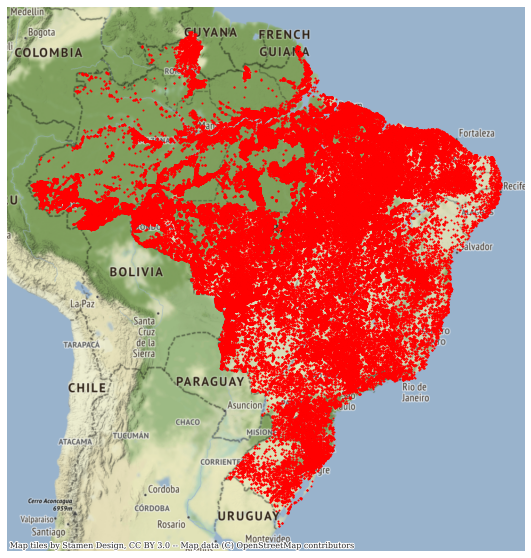

In [ ]:
ax = queimadas_brasil_2020.plot(figsize=(15, 10), markersize=1, color='red')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

### 1.2) Malhas municipais do Brasil

* Fonte: [Instituto Brasileiro de Geografia e Estatística (IBGE)](https://www.ibge.gov.br/geociencias/downloads-geociencias.html)

In [ ]:
url_brasil_malhas_municipios = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_Municipios_2020.zip'

In [ ]:
%%time

urlretrieve(url_brasil_malhas_municipios, '/mapas/BR_Municipios_2020.zip')

CPU times: user 2.37 s, sys: 1.82 s, total: 4.19 s
Wall time: 4min 45s


('/mapas/BR_Municipios_2020.zip', <http.client.HTTPMessage at 0x7ff87ece8690>)

In [ ]:
with zipfile.ZipFile('/mapas/BR_Municipios_2020.zip', 'r') as zip_ref:
    zip_ref.extractall('/mapas/')

In [ ]:
os.remove('/mapas/BR_Municipios_2020.zip')

In [ ]:
brasil_malhas_municipios = gpd.read_file('/mapas/BR_Municipios_2020.shp')

In [ ]:
brasil_malhas_municipios.shape

(5570, 5)

In [ ]:
brasil_malhas_municipios.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.00080 -11.29737, -61.00103 -11.3..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0..."


In [ ]:
brasil_malhas_municipios.crs.to_string()

'EPSG:4674'

In [ ]:
brasil_malhas_municipios.to_crs(epsg=3857, inplace=True)

In [ ]:
brasil_malhas_municipios.crs.to_string()

'EPSG:3857'

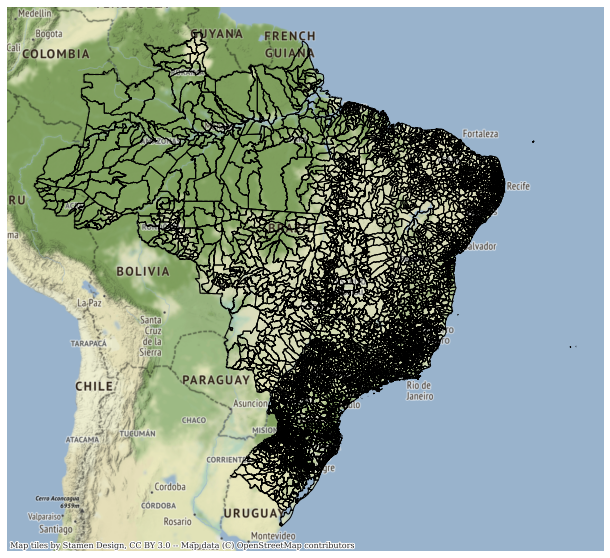

In [ ]:
ax = brasil_malhas_municipios.plot(figsize=(15, 10), edgecolor='black', facecolor='none')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

### 1.3) Localidades brasileiras

* Fonte: [Instituto Brasileiro de Geografia e Estatística (IBGE)](https://www.ibge.gov.br/geociencias/downloads-geociencias.html)

In [ ]:
url_brasil_localidades = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/estrutura_territorial/localidades/Shapefile_SHP/'

In [ ]:
req = requests.get(url_brasil_localidades)

In [ ]:
dados_ibge = BeautifulSoup(req.text, "html.parser")
dados_ibge

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">

<html>
<head>
<title>Index of /organizacao_do_territorio/estrutura_territorial/localidades/Shapefile_SHP</title>
</head>
<body>
<h1>Index of /organizacao_do_territorio/estrutura_territorial/localidades/Shapefile_SHP</h1>
<table>
<tr><th valign="top"><img alt="[ICO]" src="/icons/blank.gif"/></th><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr>
<tr><th colspan="5"><hr/></th></tr>
<tr><td valign="top"><img alt="[PARENTDIR]" src="/icons/back.gif"/></td><td><a href="/organizacao_do_territorio/estrutura_territorial/localidades/">Parent Directory</a> </td><td> </td><td align="right">  - </td><td> </td></tr>
<tr><td valign="top"><img alt="[   ]" src="/icons/unknown.gif"/></td><td><a href="BR_Localidades_2010_v1.dbf">BR_Localidades_2010_..&gt;</a></td><td align="right">2016-06-02 01:30  </td><td align="right"> 17M</td><td> 

In [ ]:
%%time

for arq in dados_ibge.find_all('a'):
    if 'BR_Localidades' in arq.get_text():
        print(arq.get_text())
        req = requests.get(url_brasil_localidades + arq["href"])
        print(req.status_code)
        open('/mapas/' + arq['href'], 'wb').write(req.content)

BR_Localidades_2010_..>
200
BR_Localidades_2010_..>
200
BR_Localidades_2010_..>
200
BR_Localidades_2010_..>
200
CPU times: user 503 ms, sys: 161 ms, total: 664 ms
Wall time: 1min


In [ ]:
brasil_localidades = gpd.read_file('BR_Localidades_2010_v1.shp')

In [ ]:
brasil_localidades.shape

(21886, 23)

In [ ]:
brasil_localidades.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_UF,CD_NIVEL,CD_CATEGOR,NM_CATEGOR,NM_LOCALID,LONG,LAT,ALT,GMRotation,geometry
0,1,110001505000001,URBANO,110001505006,Redondo,11000150500,None,110001505,ALTA FLORESTA D'OESTE,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,1,05,CIDADE,ALTA FLORESTA D'OESTE,-61.999824,-11.935540,337.735719,0.0,POINT (-61.99982 -11.93554)
1,2,110001515000001,URBANO,None,None,11000151500,None,110001515,FILADÉLFIA D'OESTE,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,15,VILA,FILADÉLFIA D'OESTE,-62.043898,-12.437239,215.244429,0.0,POINT (-62.04390 -12.43724)
2,3,110001520000001,URBANO,None,None,11000152000,None,110001520,IZIDOLÂNDIA,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,20,VILA,IZIDOLÂNDIA,-62.175549,-12.601415,181.044807,0.0,POINT (-62.17555 -12.60142)
3,4,110001525000001,URBANO,None,None,11000152500,None,110001525,NOVA GEASE D'OESTE,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,25,VILA,NOVA GEASE D'OESTE,-62.318650,-11.919792,191.576571,0.0,POINT (-62.31865 -11.91979)
4,5,110001530000001,URBANO,None,None,11000153000,None,110001530,ROLIM DE MOURA DO GUAPORÉ,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,30,VILA,ROLIM DE MOURA DO GUAPORÉ,-62.276812,-13.079806,157.285277,0.0,POINT (-62.27681 -13.07981)


In [ ]:
brasil_localidades.crs.to_string()

'EPSG:4674'

In [ ]:
brasil_localidades.to_crs(epsg=3857, inplace=True)

In [ ]:
brasil_localidades.crs.to_string()

'EPSG:3857'

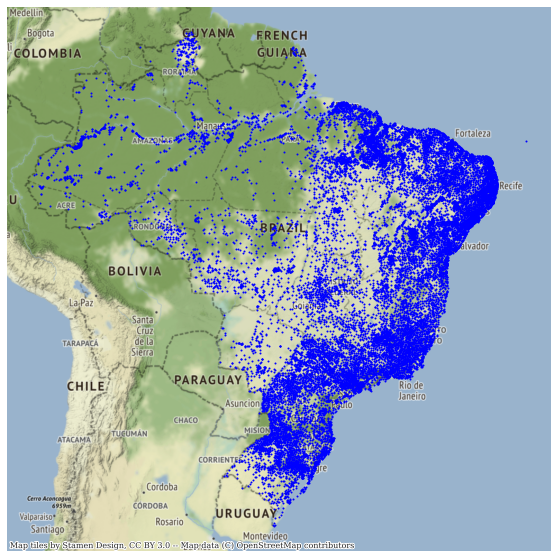

In [ ]:
ax = brasil_localidades.plot(figsize=(15, 10), markersize=1, color='blue')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

## 2) O que podemos extrair de informações dos dados?

### 2.1) Queimadas e biomas

In [ ]:
queimadas_brasil_2020.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
0,2020-10-02T17:20:00,AQUA_M-T,Brasil,RONDONIA,PIMENTA BUENO,Amazonia,2.0,1.5,0.6,-12.134,-60.634,60.0,POINT (-6749746.005 -1360962.276)
1,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.782,-42.122,111.9,POINT (-4688999.591 -532948.905)
2,2020-10-02T15:45:00,AQUA_M-T,Brasil,RIO GRANDE DO NORTE,MACAIBA,Caatinga,23.0,0.0,1.0,-5.853,-35.478,21.7,POINT (-3949392.894 -652689.155)
3,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,1.0,-17.227,-56.058,39.1,POINT (-6240348.015 -1947265.259)
4,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,0.7,-20.235,-57.487,22.2,POINT (-6399423.567 -2300890.781)


In [ ]:
queimadas_brasil_2020['bioma'].unique()

array(['Amazonia', 'Caatinga', 'Pantanal', 'Cerrado', 'Mata Atlantica',
       'Pampa'], dtype=object)

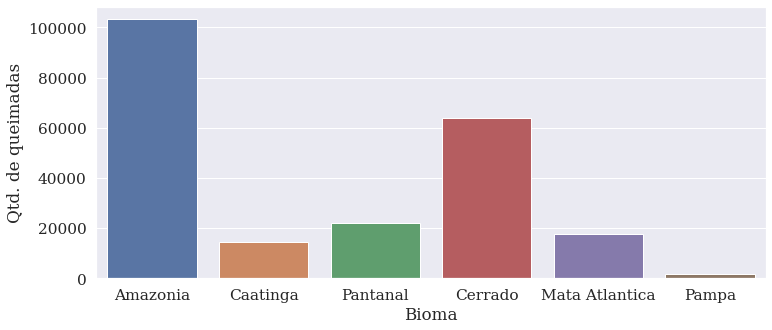

In [ ]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='bioma', data=queimadas_brasil_2020)
ax.set_xlabel('Bioma')
ax.set_ylabel('Qtd. de queimadas')
plt.show()

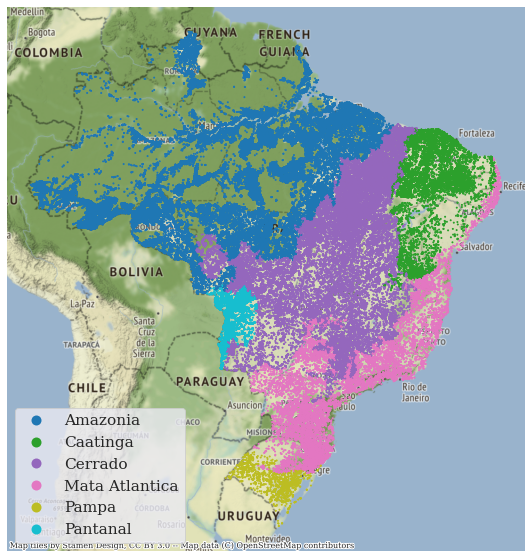

In [ ]:
ax = queimadas_brasil_2020.plot(figsize=(15, 10), column='bioma', markersize=1, legend=True)
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

### 2.2) Filtrando e visualizando o risco de fogo

In [ ]:
queimadas_brasil_2020.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
0,2020-10-02T17:20:00,AQUA_M-T,Brasil,RONDONIA,PIMENTA BUENO,Amazonia,2.0,1.5,0.6,-12.134,-60.634,60.0,POINT (-6749746.005 -1360962.276)
1,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.782,-42.122,111.9,POINT (-4688999.591 -532948.905)
2,2020-10-02T15:45:00,AQUA_M-T,Brasil,RIO GRANDE DO NORTE,MACAIBA,Caatinga,23.0,0.0,1.0,-5.853,-35.478,21.7,POINT (-3949392.894 -652689.155)
3,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,1.0,-17.227,-56.058,39.1,POINT (-6240348.015 -1947265.259)
4,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,0.7,-20.235,-57.487,22.2,POINT (-6399423.567 -2300890.781)


In [ ]:
queimadas_risco_alto = queimadas_brasil_2020[queimadas_brasil_2020['riscofogo'] >= 1]
queimadas_risco_alto.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry
1,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.782,-42.122,111.9,POINT (-4688999.591 -532948.905)
2,2020-10-02T15:45:00,AQUA_M-T,Brasil,RIO GRANDE DO NORTE,MACAIBA,Caatinga,23.0,0.0,1.0,-5.853,-35.478,21.7,POINT (-3949392.894 -652689.155)
3,2020-10-02T17:20:00,AQUA_M-T,Brasil,MATO GROSSO DO SUL,CORUMBA,Pantanal,4.0,0.0,1.0,-17.227,-56.058,39.1,POINT (-6240348.015 -1947265.259)
5,2020-10-02T17:20:00,AQUA_M-T,Brasil,BAHIA,COTEGIPE,Cerrado,10.0,0.0,1.0,-12.031,-44.364,113.5,POINT (-4938577.890 -1349236.611)
8,2020-10-02T17:20:00,AQUA_M-T,Brasil,GOIAS,RIO VERDE,Cerrado,9.0,0.0,1.0,-17.787,-51.029,61.4,POINT (-5680522.296 -2012632.258)


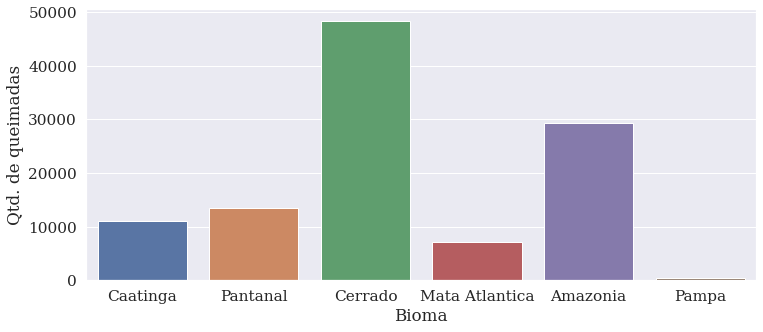

In [ ]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='bioma', data=queimadas_risco_alto)
ax.set_xlabel('Bioma')
ax.set_ylabel('Qtd. de queimadas')
plt.show()

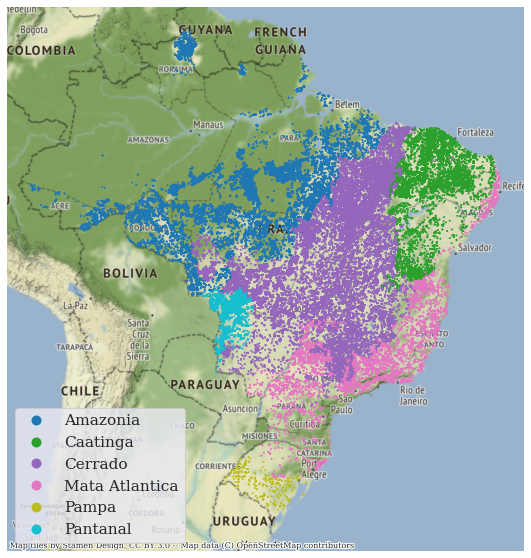

In [ ]:
ax = queimadas_risco_alto.plot(figsize=(15, 10), column='bioma', markersize=1, legend=True)
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

### 2.3) Entendendo as categorias das localidades

In [ ]:
brasil_localidades.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_UF,CD_NIVEL,CD_CATEGOR,NM_CATEGOR,NM_LOCALID,LONG,LAT,ALT,GMRotation,geometry
0,1,110001505000001,URBANO,110001505006,Redondo,11000150500,None,110001505,ALTA FLORESTA D'OESTE,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,1,05,CIDADE,ALTA FLORESTA D'OESTE,-61.999824,-11.935540,337.735719,0.0,POINT (-6901788.825 -1338373.356)
1,2,110001515000001,URBANO,None,None,11000151500,None,110001515,FILADÉLFIA D'OESTE,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,15,VILA,FILADÉLFIA D'OESTE,-62.043898,-12.437239,215.244429,0.0,POINT (-6906695.095 -1395509.874)
2,3,110001520000001,URBANO,None,None,11000152000,None,110001520,IZIDOLÂNDIA,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,20,VILA,IZIDOLÂNDIA,-62.175549,-12.601415,181.044807,0.0,POINT (-6921350.509 -1414231.090)
3,4,110001525000001,URBANO,None,None,11000152500,None,110001525,NOVA GEASE D'OESTE,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,25,VILA,NOVA GEASE D'OESTE,-62.318650,-11.919792,191.576571,0.0,POINT (-6937280.400 -1336581.629)
4,5,110001530000001,URBANO,None,None,11000153000,None,110001530,ROLIM DE MOURA DO GUAPORÉ,1100015,ALTA FLORESTA D'OESTE,CACOAL,LESTE RONDONIENSE,RONDÔNIA,2,30,VILA,ROLIM DE MOURA DO GUAPORÉ,-62.276812,-13.079806,157.285277,0.0,POINT (-6932623.030 -1468851.439)


In [ ]:
brasil_localidades['NM_CATEGOR'].unique()

array(['CIDADE', 'VILA', 'POVOADO', 'ALDEIA INDÍGENA', 'NÚCLEO',
       'PROJETO DE ASSENTAMENTO', 'LUGAREJO', 'AUI'], dtype=object)

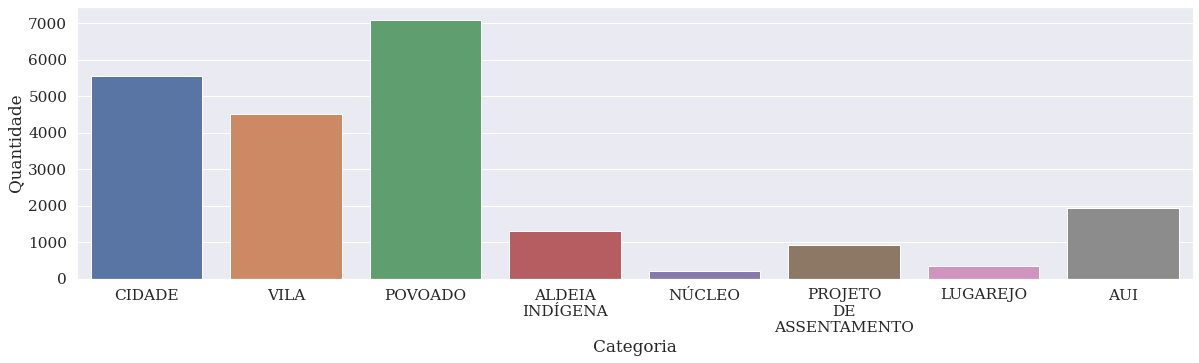

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='NM_CATEGOR', data=brasil_localidades)
ax.set_xlabel('Categoria')

labels = [l.replace(' ', '\n') for l in brasil_localidades['NM_CATEGOR'].unique()]
ax.set_xticklabels(labels=labels)

ax.set_ylabel('Quantidade')
plt.show()

In [ ]:
aldeias_indigenas = brasil_localidades[brasil_localidades['NM_CATEGOR'] == 'ALDEIA INDÍGENA']
aldeias_indigenas.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_UF,CD_NIVEL,CD_CATEGOR,NM_CATEGOR,NM_LOCALID,LONG,LAT,ALT,GMRotation,geometry
11,12,110004910000027,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00007,ALDEIA INDÍGENA,ALDEIA INDÍGENA SURUÍ - LINHA 14,-61.180935,-11.190620,256.534383,0.0,POINT (-6810630.543 -1253730.758)
12,13,110004910000028,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00006,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 14,-61.176371,-11.231878,258.142759,0.0,POINT (-6810122.501 -1258412.863)
13,14,110004910000029,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00005,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 12,-61.248991,-11.220610,205.526414,0.0,POINT (-6818206.488 -1257134.108)
14,15,110004910000030,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00004,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 11,-61.305255,-11.175844,227.287546,0.0,POINT (-6824469.743 -1252054.064)
15,16,110004910000032,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00003,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 10,-61.322750,-11.095900,197.418105,0.0,POINT (-6826417.250 -1242983.941)


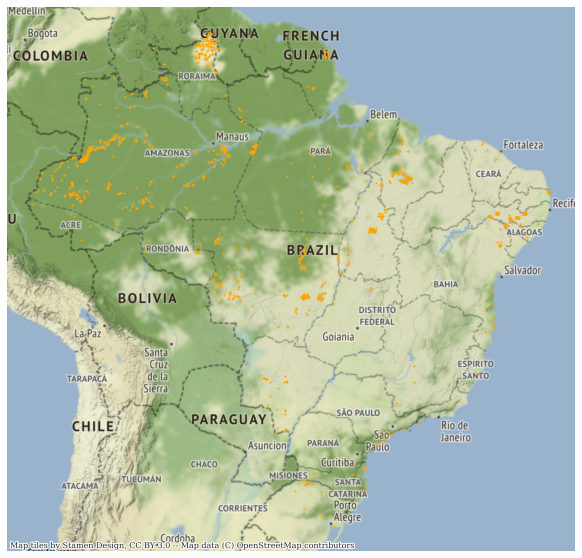

In [ ]:
ax = aldeias_indigenas.plot(figsize=(15, 10), markersize=1, color='orange')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

## 3) Trabalhando com camadas de dados

In [ ]:
aldeias_indigenas.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,NM_UF,CD_NIVEL,CD_CATEGOR,NM_CATEGOR,NM_LOCALID,LONG,LAT,ALT,GMRotation,geometry
11,12,110004910000027,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00007,ALDEIA INDÍGENA,ALDEIA INDÍGENA SURUÍ - LINHA 14,-61.180935,-11.190620,256.534383,0.0,POINT (-6810630.543 -1253730.758)
12,13,110004910000028,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00006,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 14,-61.176371,-11.231878,258.142759,0.0,POINT (-6810122.501 -1258412.863)
13,14,110004910000029,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00005,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 12,-61.248991,-11.220610,205.526414,0.0,POINT (-6818206.488 -1257134.108)
14,15,110004910000030,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00004,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 11,-61.305255,-11.175844,227.287546,0.0,POINT (-6824469.743 -1252054.064)
15,16,110004910000032,RURAL,None,None,11000491000,None,110004910,RIOZINHO,1100049,CACOAL,CACOAL,LESTE RONDONIENSE,RONDÔNIA,5,00003,ALDEIA INDÍGENA,ALDEIA INDÍGENA - LINHA 10,-61.322750,-11.095900,197.418105,0.0,POINT (-6826417.250 -1242983.941)


In [ ]:
aldeia = aldeias_indigenas.loc[11, 'geometry']

In [ ]:
dist_aldeia = queimadas_risco_alto.distance(aldeia)
dist_aldeia

1         2.240724e+06
2         2.923685e+06
3         8.978932e+05
5         1.874487e+06
8         1.361277e+06
              ...     
222789    2.111241e+06
222790    2.280650e+06
222791    2.073080e+06
222792    2.583630e+06
222793    2.330220e+06
Length: 109554, dtype: float64

In [ ]:
dist_aldeia.min()

7519.118055229182

In [ ]:
agregados = gpd.sjoin(queimadas_risco_alto, brasil_malhas_municipios, op='within')

In [ ]:
agregados.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,geometry,index_right,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2
1,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.782,-42.122,111.9,POINT (-4688999.591 -532948.905),713,2202208,Campo Maior,PI,1680.861
50059,2020-08-07T16:35:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,22.0,0.0,1.0,-4.852,-42.099,35.2,POINT (-4686439.243 -540768.890),713,2202208,Campo Maior,PI,1680.861
50060,2020-08-07T16:35:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,22.0,0.0,1.0,-4.851,-42.089,27.7,POINT (-4685326.048 -540657.170),713,2202208,Campo Maior,PI,1680.861
123177,2020-09-12T16:10:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,25.0,0.0,1.0,-5.042,-42.124,23.1,POINT (-4689222.230 -561998.686),713,2202208,Campo Maior,PI,1680.861
164478,2020-10-02T15:45:00,AQUA_M-T,Brasil,PIAUI,CAMPO MAIOR,Caatinga,78.0,0.0,1.0,-4.765,-42.125,151.0,POINT (-4689333.550 -531049.886),713,2202208,Campo Maior,PI,1680.861


In [ ]:
queimadas_muni = agregados.groupby(by='NM_MUN').size()
queimadas_muni

NM_MUN
Abadia de Goiás            5
Abadia dos Dourados        8
Abadiânia                 14
Abaeté                    14
Abaiara                    4
                          ..
Águas de Santa Bárbara     5
Águia Branca               1
Álvares Florence          12
Érico Cardoso              2
Óbidos                    64
Length: 3349, dtype: int64

In [ ]:
queimadas_muni

NM_MUN
Abadia de Goiás            5
Abadia dos Dourados        8
Abadiânia                 14
Abaeté                    14
Abaiara                    4
                          ..
Águas de Santa Bárbara     5
Águia Branca               1
Álvares Florence          12
Érico Cardoso              2
Óbidos                    64
Length: 3349, dtype: int64